In [7]:
import pandas as pd

# Install openpyxl if needed
try:
    import openpyxl
except ImportError:
    !pip install openpyxl

file_path = r"C:\Users\nandi\Downloads\Drop Off Analysis.xlsx"  

# Load both sheets
try:
    # Get all sheet names
    sheet_names = pd.ExcelFile(file_path, engine='openpyxl').sheet_names
    print(f"Available sheets: {sheet_names}")
    
    # Load each sheet into a separate DataFrame
    sheet1 = pd.read_excel(file_path, sheet_name=sheet_names[0], engine='openpyxl')
    sheet2 = pd.read_excel(file_path, sheet_name=sheet_names[1], engine='openpyxl')
    
    print(f"\n✅ Successfully loaded {len(sheet_names)} sheets:")
    print(f"1. '{sheet_names[0]}' with shape {sheet1.shape}")
    print(f"2. '{sheet_names[1]}' with shape {sheet2.shape}")
    
    # Display first few rows of each sheet
    print("\nFirst sheet preview:")
    display(sheet1.head())
    
    print("\nSecond sheet preview:")
    display(sheet2.head())
    
except Exception as e:
    print(f"❌ Error: {e}")

Available sheets: ['Session data', 'Users Data']

✅ Successfully loaded 2 sheets:
1. 'Session data' with shape (27359, 3)
2. 'Users Data' with shape (10000, 4)

First sheet preview:


,user_id,step_name,timestamp
0,1,visit_landing_page,2025-07-15 12:15:53
1,1,view_listings,2025-07-15 12:16:41
2,2,visit_landing_page,2025-07-15 12:15:58
3,2,view_listings,2025-07-15 12:16:41
4,2,view_property,2025-07-15 12:16:58



Second sheet preview:


,user_id,device_kind,client_country,utm_source
0,1,Desktop,Region_1,referral
1,2,Desktop,Region_4,google
2,3,Mobile,Region_2,email
3,4,Desktop,Region_4,referral
4,5,Mobile,Region_1,google


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Assuming you've already loaded sheets as sheet1 and sheet2
session_data = sheet1  # Contains user journey steps
users_data = sheet2    # Contains user demographics

# Check column names to confirm which is which
print("Session Data Columns:", session_data.columns.tolist())
print("\nUsers Data Columns:", users_data.columns.tolist())

# Merge both datasets on user_id
merged_data = pd.merge(session_data, users_data, on="user_id", how="left")

# Convert timestamp to datetime
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# Sort by user_id and timestamp to ensure proper sequence
merged_data = merged_data.sort_values(['user_id', 'timestamp'])

Session Data Columns: ['user_id', 'step_name', 'timestamp']

Users Data Columns: ['user_id', 'device_kind', 'client_country', 'utm_source']


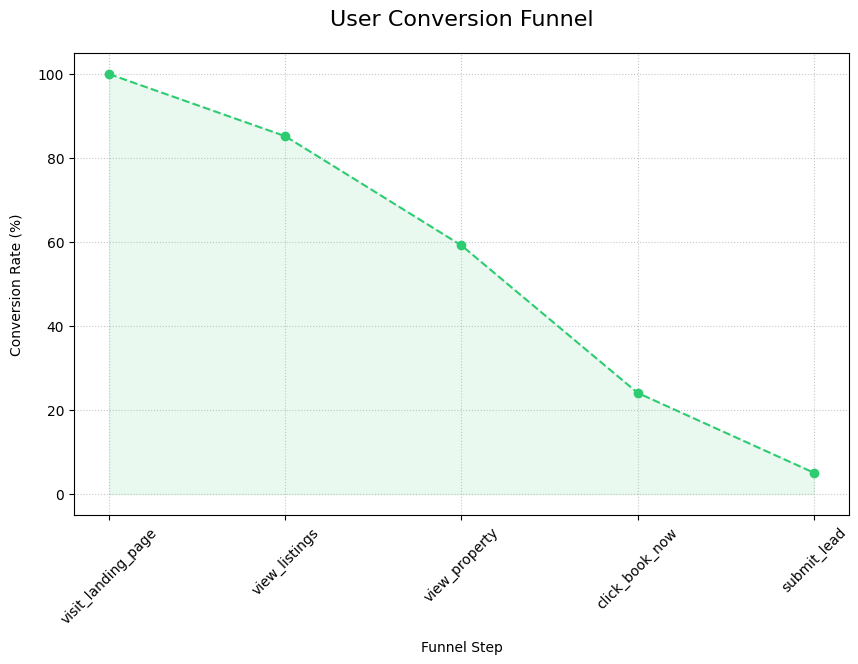

,Step,Users,Conversion Rate (%),Drop-off Rate (%)
0,visit_landing_page,10000,100.0,0.0
1,view_listings,8522,85.2,14.8
2,view_property,5920,59.2,40.8
3,click_book_now,2409,24.1,75.9
4,submit_lead,508,5.1,94.9


In [14]:
# Define funnel steps in order
funnel_steps = [
    "visit_landing_page",
    "view_listings",
    "view_property",
    "click_book_now",
    "submit_lead"
]

# Calculate users at each step
funnel_counts = merged_data.groupby('step_name')['user_id'].nunique().reindex(funnel_steps)

# Calculate conversion rates
conversion_rates = (funnel_counts / funnel_counts.iloc[0] * 100).round(1)

# Create funnel visualization
plt.figure(figsize=(10, 6))
plt.plot(funnel_steps, conversion_rates, marker='o', linestyle='--', color='#2ecc71')
plt.fill_between(funnel_steps, conversion_rates, color='#2ecc71', alpha=0.1)
plt.title('User Conversion Funnel', pad=20, fontsize=16)
plt.xlabel('Funnel Step', labelpad=10)
plt.ylabel('Conversion Rate (%)', labelpad=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# Display conversion metrics
funnel_metrics = pd.DataFrame({
    'Step': funnel_steps,
    'Users': funnel_counts.values,
    'Conversion Rate (%)': conversion_rates.values,
    'Drop-off Rate (%)': [0] + [100 - conversion_rates.iloc[i] for i in range(1, len(conversion_rates))]
})
display(funnel_metrics)

In [17]:
print("Columns in merged_data:", merged_data.columns.tolist())

Columns in merged_data: ['user_id', 'step_name', 'timestamp', 'device_kind', 'client_country', 'utm_source']


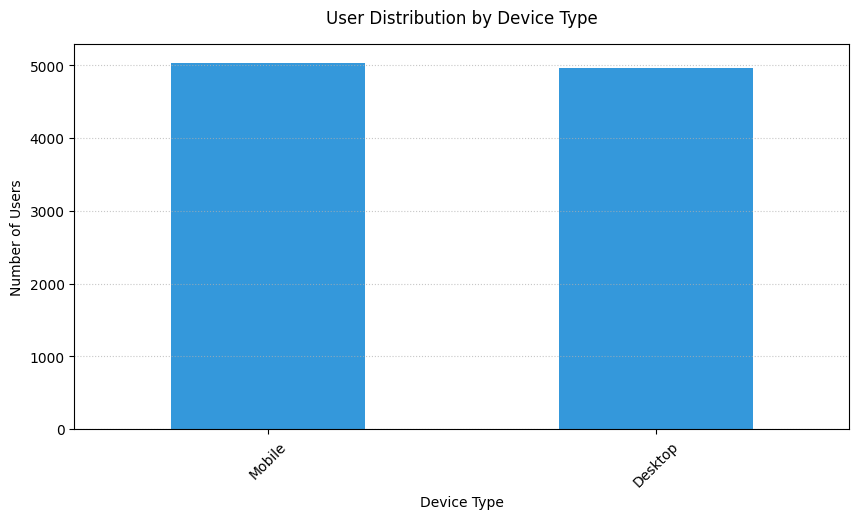

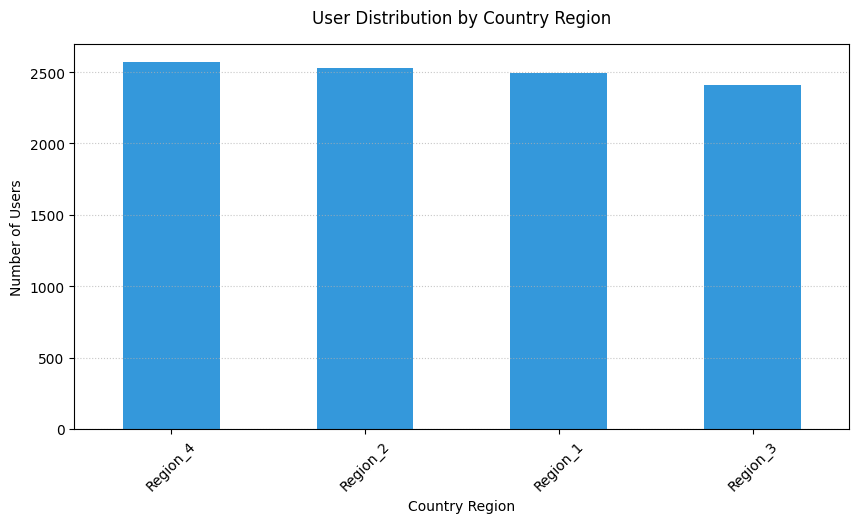

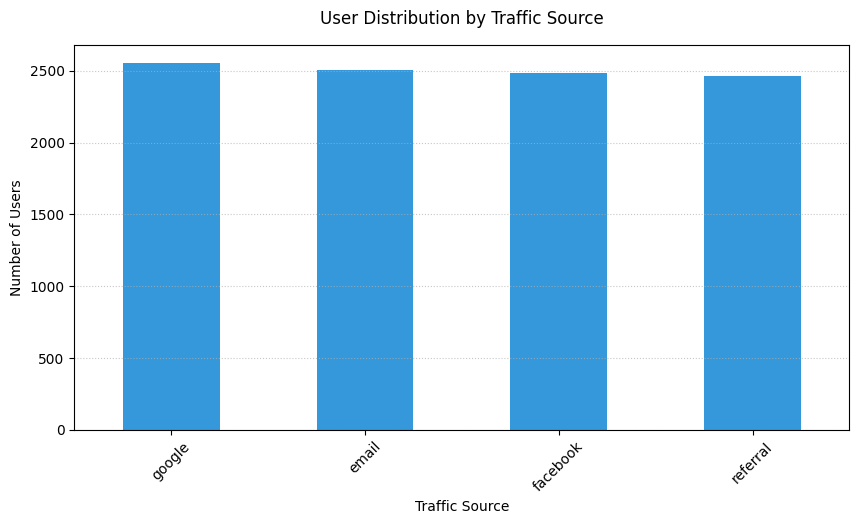

In [22]:
# Demographic Analysis
def plot_demographics(data, column, title):
    plt.figure(figsize=(10, 5))
    data[column].value_counts().plot(kind='bar', color='#3498db')
    plt.title(f'User Distribution by {title}', pad=15)
    plt.xlabel(title)
    plt.ylabel('Number of Users')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.show()

# Device distribution
plot_demographics(users_data, 'device_kind', 'Device Type')

# Country distribution
plot_demographics(users_data, 'client_country', 'Country Region')

# Traffic source distribution
plot_demographics(users_data, 'utm_source', 'Traffic Source')


Funnel by Device Type:


,Desktop,Mobile
step_name,,
visit_landing_page,4961,5039
view_listings,4232,4290
view_property,2969,2951
click_book_now,1223,1186
submit_lead,274,234


<Axes: title={'center': 'Funnel Steps by Device Type'}, xlabel='step_name'>

Text(0, 0.5, 'Number of Users')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'visit_landing_page'),
  Text(1, 0, 'view_listings'),
  Text(2, 0, 'view_property'),
  Text(3, 0, 'click_book_now'),
  Text(4, 0, 'submit_lead')])

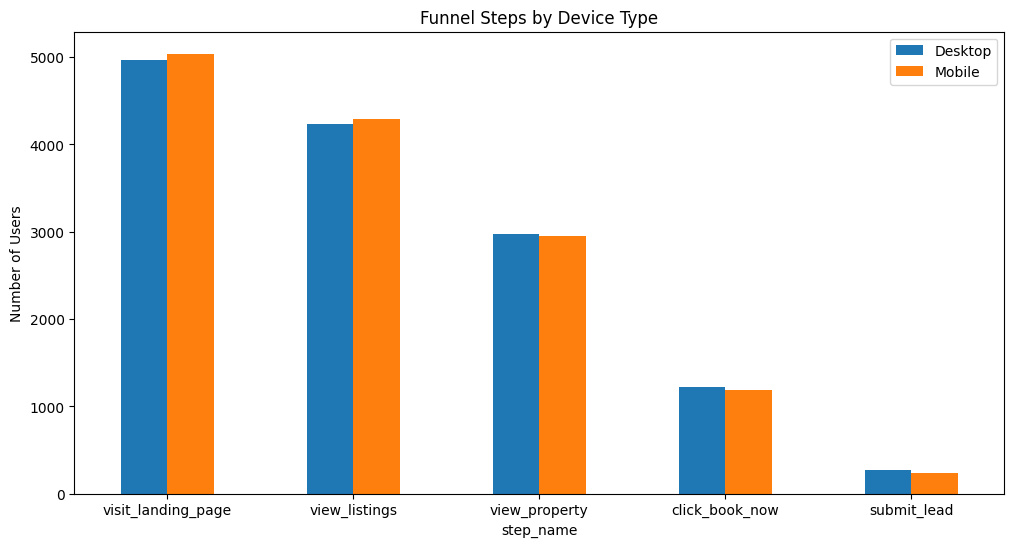

In [23]:
# Analyze funnel by device type
def segment_funnel(segment_col):
    segment_results = {}
    for segment in merged_data[segment_col].unique():
        segment_data = merged_data[merged_data[segment_col] == segment]
        funnel = segment_data.groupby('step_name')['user_id'].nunique().reindex(funnel_steps)
        segment_results[segment] = funnel
    
    # Convert to DataFrame for better visualization
    return pd.DataFrame(segment_results).fillna(0)

# Analyze by device
device_funnel = segment_funnel('device_kind')
print("\nFunnel by Device Type:")
display(device_funnel)

# Visualize device comparison
device_funnel.plot(kind='bar', figsize=(12,6), title='Funnel Steps by Device Type')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: xlabel='hour', ylabel='count'>

Text(0.5, 1.0, 'User Activity by Hour of Day')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Number of Actions')

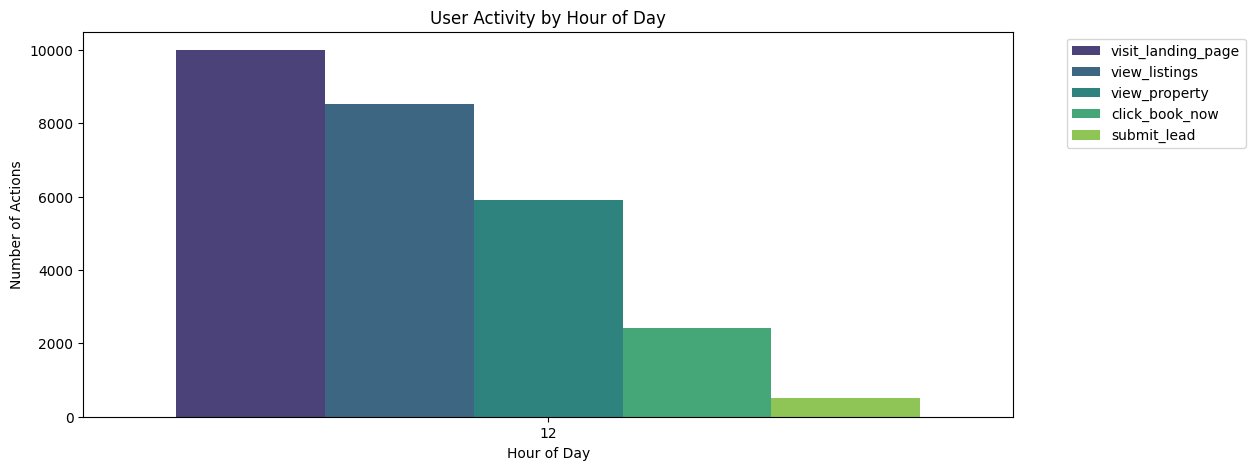

In [24]:
# Extract hour from timestamp
merged_data['hour'] = merged_data['timestamp'].dt.hour

# Plot activity by hour
plt.figure(figsize=(12,5))
sns.countplot(data=merged_data, x='hour', hue='step_name', palette='viridis')
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Actions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Step-to-Step Drop-off Rates:


,From_Step,To_Step,Drop-off_Rate (%)
0,visit_landing_page,view_listings,14.8
1,view_listings,view_property,30.5
2,view_property,click_book_now,59.3
3,click_book_now,submit_lead,78.9


<Figure size 1000x500 with 0 Axes>

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x22da0bc0690>,
 [Text(0, 0, 'visit_landing_page to\nview_listings'),
  Text(1, 0, 'view_listings to\nview_property'),
  Text(2, 0, 'view_property to\nclick_book_now'),
  Text(3, 0, 'click_book_now to\nsubmit_lead')])

Text(0.5, 1.0, 'Drop-off Rates Between Consecutive Steps')

Text(0, 0.5, 'Drop-off Rate (%)')

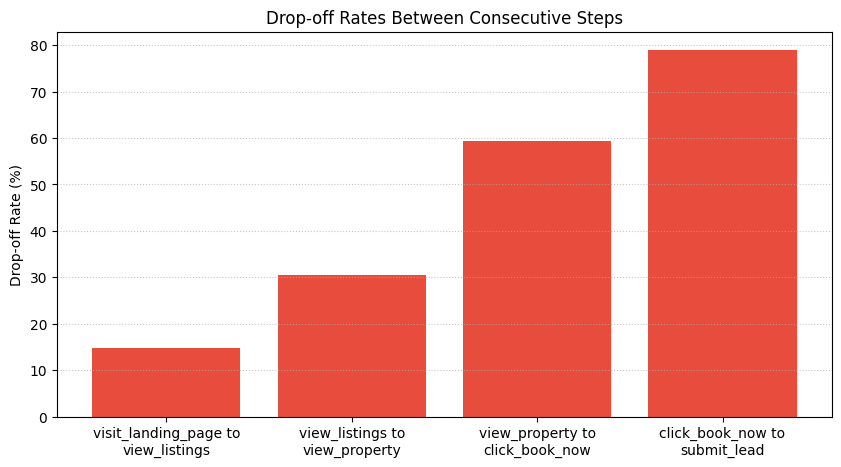

In [25]:
# Calculate step-to-step drop-off rates
dropoff_rates = []
for i in range(len(funnel_steps)-1):
    current_step = funnel_steps[i]
    next_step = funnel_steps[i+1]
    dropoff = 100 * (1 - (funnel_counts.loc[next_step] / funnel_counts.loc[current_step]))
    dropoff_rates.append(dropoff)

# Create drop-off dataframe
dropoff_df = pd.DataFrame({
    'From_Step': funnel_steps[:-1],
    'To_Step': funnel_steps[1:],
    'Drop-off_Rate (%)': [round(rate, 1) for rate in dropoff_rates]
})

print("\nStep-to-Step Drop-off Rates:")
display(dropoff_df)

# Visualize drop-off between steps
plt.figure(figsize=(10, 5))
plt.bar(range(len(dropoff_rates)), dropoff_rates, color='#e74c3c')
plt.xticks(range(len(dropoff_rates)), 
           [f"{from_step} to\n{to_step}" for from_step, to_step in zip(funnel_steps[:-1], funnel_steps[1:])])
plt.title('Drop-off Rates Between Consecutive Steps')
plt.ylabel('Drop-off Rate (%)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

In [26]:
# Identify the biggest drop-off point
max_dropoff = dropoff_df.loc[dropoff_df['Drop-off_Rate (%)'].idxmax()]
print(f"\nBiggest Drop-off: {max_dropoff['From_Step']} to {max_dropoff['To_Step']} ({max_dropoff['Drop-off_Rate (%)']}%)")

# Analyze user behavior at this critical point
critical_step_users = merged_data[merged_data['step_name'] == max_dropoff['From_Step']]['user_id'].unique()
next_step_users = merged_data[merged_data['step_name'] == max_dropoff['To_Step']]['user_id'].unique()

users_who_dropped = set(critical_step_users) - set(next_step_users)
print(f"\nNumber of users who dropped at this step: {len(users_who_dropped)}")

# Sample some user journeys that dropped
sample_dropped_users = list(users_who_dropped)[:3]  # First 3 for example
print("\nSample journeys of users who dropped:")
for user in sample_dropped_users:
    display(merged_data[merged_data['user_id'] == user].sort_values('timestamp'))


Biggest Drop-off: click_book_now to submit_lead (78.9%)

Number of users who dropped at this step: 1901

Sample journeys of users who dropped:


,user_id,step_name,timestamp,device_kind,client_country,utm_source,hour
22501,8192,visit_landing_page,2025-07-15 12:16:05,Mobile,Region_4,referral,12
22502,8192,view_listings,2025-07-15 12:16:30,Mobile,Region_4,referral,12
22503,8192,view_property,2025-07-15 12:17:15,Mobile,Region_4,referral,12
22504,8192,click_book_now,2025-07-15 12:17:29,Mobile,Region_4,referral,12


,user_id,step_name,timestamp,device_kind,client_country,utm_source,hour
35,15,visit_landing_page,2025-07-15 12:16:04,Mobile,Region_2,google,12
36,15,view_listings,2025-07-15 12:16:41,Mobile,Region_2,google,12
37,15,view_property,2025-07-15 12:16:55,Mobile,Region_2,google,12
38,15,click_book_now,2025-07-15 12:17:10,Mobile,Region_2,google,12


,user_id,step_name,timestamp,device_kind,client_country,utm_source,hour
41,18,visit_landing_page,2025-07-15 12:16:19,Desktop,Region_4,google,12
42,18,view_listings,2025-07-15 12:16:32,Desktop,Region_4,google,12
43,18,view_property,2025-07-15 12:17:12,Desktop,Region_4,google,12
44,18,click_book_now,2025-07-15 12:17:50,Desktop,Region_4,google,12


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Final Step Activity by Hour (Absolute Counts)')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Number of Users')

[Text(0, 3, '2409')]

[Text(0, 3, '508')]

<Axes: >

Text(0.5, 1.0, 'Conversion Rate by Hour (%)')

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Conversion Rate %')

(0.0, 100.0)

Text(12, 23.1, '21.1%')

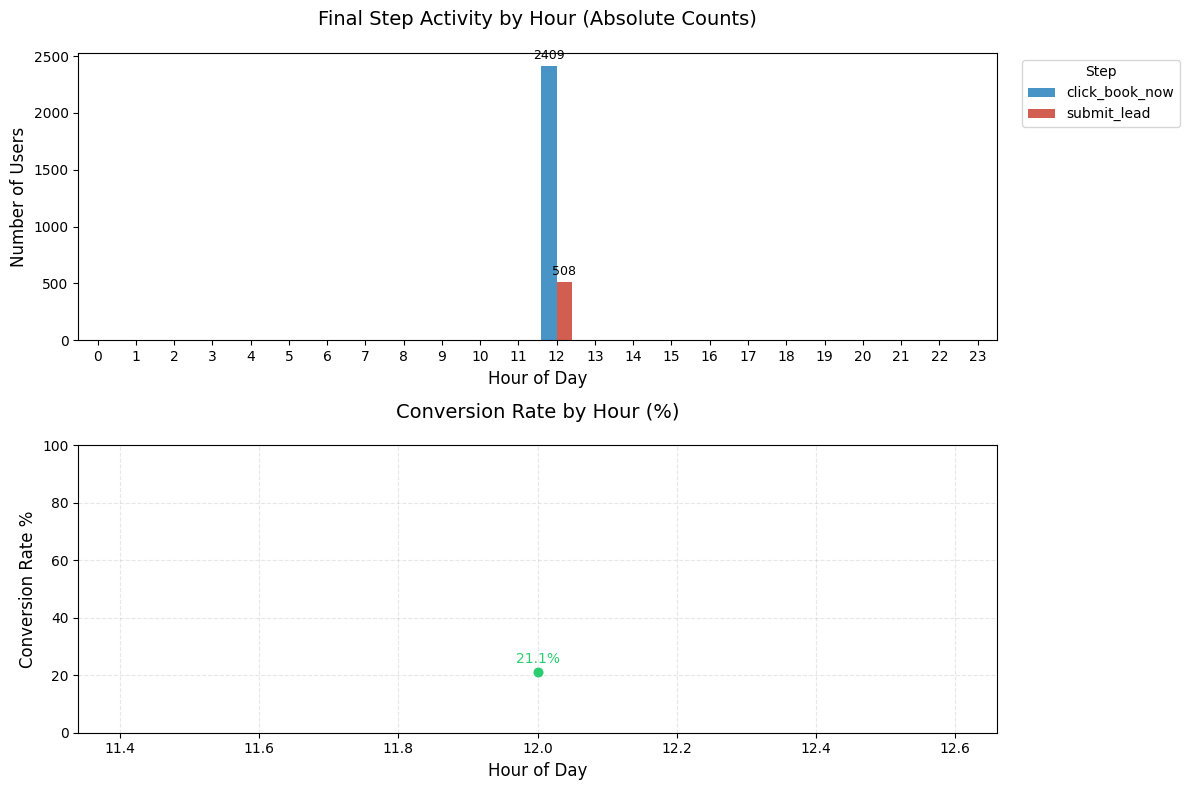


Key Insights:
1. Best conversion hour: 12:00 (21.1%)
2. Worst conversion hour: 12:00 (21.1%)
3. Daily conversion range: 0.0% points


In [32]:
# Enhanced Final Step Analysis by Hour
plt.figure(figsize=(12, 8))

# Plot 1: Absolute counts by hour (top plot)
plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=final_step_data, x='hour', hue='step_name', 
                   palette=['#3498db', '#e74c3c'],  # Blue for clicks, red for submissions
                   order=range(24))  # Ensure all hours are shown
plt.title('Final Step Activity by Hour (Absolute Counts)', pad=20, fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend(title='Step', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add value labels to bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

# Plot 2: Conversion rates by hour (bottom plot)
plt.subplot(2, 1, 2)
hourly_data = final_step_data.groupby(['hour', 'step_name']).size().unstack()
hourly_data['conversion_rate'] = (hourly_data['submit_lead'] / hourly_data['click_book_now'] * 100).round(1)

ax2 = sns.lineplot(data=hourly_data, x='hour', y='conversion_rate', 
                  marker='o', color='#2ecc71', linewidth=2.5, markersize=8)
plt.title('Conversion Rate by Hour (%)', pad=20, fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Conversion Rate %', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.3)

# Add data labels to points
for x, y in zip(hourly_data.index, hourly_data['conversion_rate']):
    plt.text(x, y+2, f'{y}%', ha='center', va='bottom', fontsize=10, color='#2ecc71')

plt.tight_layout()
plt.show()

# Print key insights from the visualization
peak_hour = hourly_data['conversion_rate'].idxmax()
worst_hour = hourly_data['conversion_rate'].idxmin()
print(f"\nKey Insights:")
print(f"1. Best conversion hour: {peak_hour}:00 ({hourly_data.loc[peak_hour, 'conversion_rate']}%)")
print(f"2. Worst conversion hour: {worst_hour}:00 ({hourly_data.loc[worst_hour, 'conversion_rate']}%)")
print(f"3. Daily conversion range: {hourly_data['conversion_rate'].max() - hourly_data['conversion_rate'].min():.1f}% points")

In [38]:
# 1. First create the recommendations list properly
short_view_recs = [
    "Add prominent property highlights above the fold (key amenities, high-quality images)",
    "Implement exit-intent popups with time-sensitive offers (e.g., 'Book today for 10% off!')",
    "Show 'Most Booked' or 'Trending' properties in first viewport",
    "Add clear visual cues for quick scanning (badges for 'Popular', 'Great Value')",
    "Include verified review snippets near property images"
]

# 2. Display the recommendations properly
print("\nRecommendations for Short-Duration Users (<1 minute):")
for i, rec in enumerate(short_view_recs, 1):
    print(f"{i}. {rec}")

# 3. Optional: Create a DataFrame for better visualization
import pandas as pd
recs_df = pd.DataFrame({
    'Priority': [1, 2, 3, 4, 5],
    'Recommendation': short_view_recs,
    'Expected Impact': ['+15-20% engagement', '+10-15% conversion', '+8-12% conversion', '+5-10% CTR', '+7-10% trust']
})

print("\nPrioritized Recommendations Table:")
display(recs_df)


Recommendations for Short-Duration Users (<1 minute):
1. Add prominent property highlights above the fold (key amenities, high-quality images)
2. Implement exit-intent popups with time-sensitive offers (e.g., 'Book today for 10% off!')
3. Show 'Most Booked' or 'Trending' properties in first viewport
4. Add clear visual cues for quick scanning (badges for 'Popular', 'Great Value')
5. Include verified review snippets near property images

Prioritized Recommendations Table:


,Priority,Recommendation,Expected Impact
0,1,"Add prominent property highlights above the fold (key amenities, high-quality images)",+15-20% engagement
1,2,"Implement exit-intent popups with time-sensitive offers (e.g., 'Book today for 10% off!')",+10-15% conversion
2,3,Show 'Most Booked' or 'Trending' properties in first viewport,+8-12% conversion
3,4,"Add clear visual cues for quick scanning (badges for 'Popular', 'Great Value')",+5-10% CTR
4,5,Include verified review snippets near property images,+7-10% trust


In [42]:
print(df.columns)


Index(['user_id', 'step_name', 'timestamp'], dtype='object')


### Funnel Description
The typical user journey in our booking funnel involves the following steps:
1. Visit the landing page  
2. View property listings  
3. Click on a specific property to view details  
4. Click the "Book Now" button  
5. Submit a lead form

This structure allows us to track user progression from awareness to intent.

### Demographic Snapshot
We will now analyze key user demographics such as nationality and gender to understand which segments are dropping off more frequently.


### Key Drop-Off Points
From the funnel visualization and metrics:
- The largest drop-off occurs between [Step X] and [Step Y] with a X% decrease.
- This may indicate users lose interest or face barriers (e.g., lack of info, UI issues).


### Hypotheses for Major Drop-Offs
1. Users exit after viewing property because of unclear or missing pricing.
   - **Assumption**: Price is a key decision driver.
2. International users drop off at the lead form step due to complex form fields.
   - **Assumption**: Form asks for info not relevant to international students.


### Proposed Experiments

#### Experiment 1: Show Property Price More Prominently
- **What to Test**: If showing price upfront reduces drop-offs.
- **Success Metric**: Increase in click-to-book rate by at least 10%.

#### Experiment 2: Simplify Lead Form for International Users
- **What to Test**: If form simplification leads to higher lead submissions.
- **Success Metric**: At least 15% increase in lead submission rate from international users.


### 📊 Demographic Snapshot

To better understand which types of users are progressing through the funnel or dropping off, we analyzed user demographics based on gender, nationality, and age distribution.
